In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn

In [73]:
entropy = pd.read_csv("entropies.csv")
accuracy = pd.read_csv("RFCs_accuracy.csv")
cm = pd.read_csv("classif_metric.csv")

entropy["cond_entropy"] = entropy["cond_entropy"]/max(entropy["cond_entropy"])
cm["cm"] = cm["cm"]/max(cm["cm"])

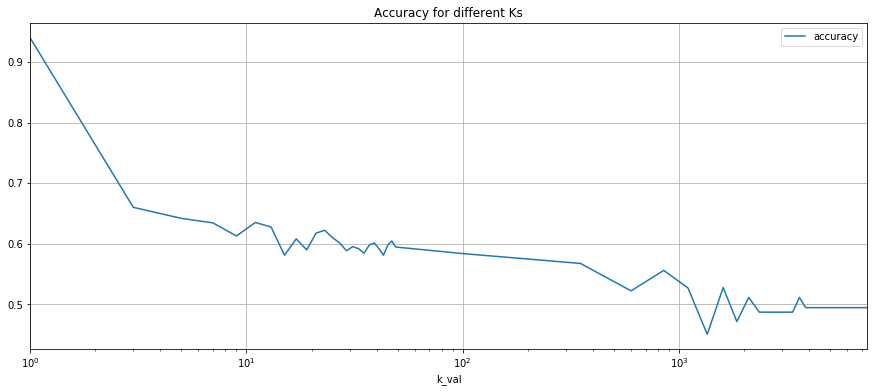

In [74]:
accuracy.plot("k_val", "accuracy", figsize=(15,6), grid=True, logx=True, title="Accuracy for different Ks")

In [75]:
data = pd.DataFrame()
data[["k_val","accuracy"]] = accuracy[["k_val", "accuracy"]]
data = data.merge(entropy)
data = data.merge(cm)

In [110]:
data.head()

,k_val,accuracy,cond_entropy,cm
0,1,0.939865,0.000000,0.000000
1,3,0.660135,0.952428,0.495087
2,5,0.641892,0.956839,0.581605
3,7,0.634459,0.956854,0.581332
4,9,0.612838,0.961178,0.647107


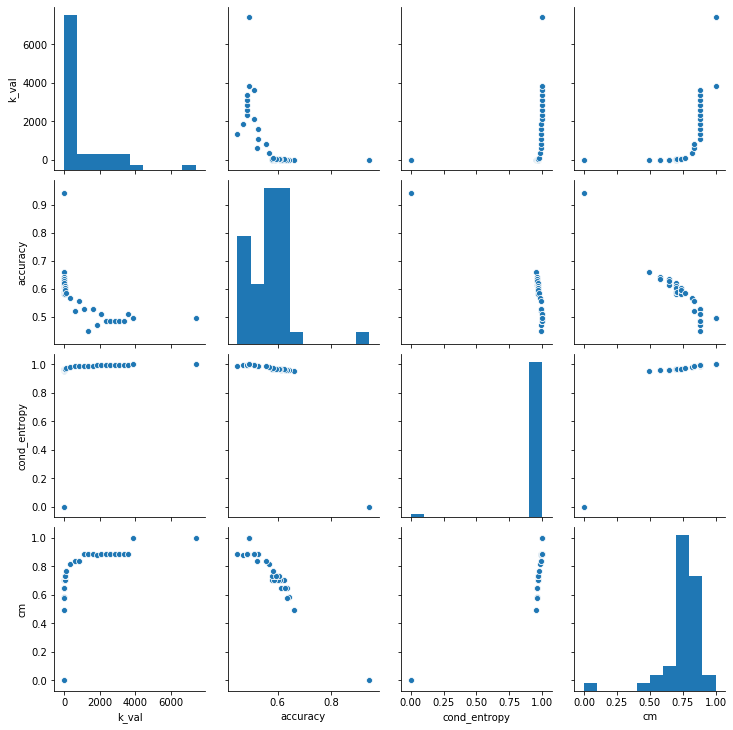

In [79]:
sbn.pairplot(data)

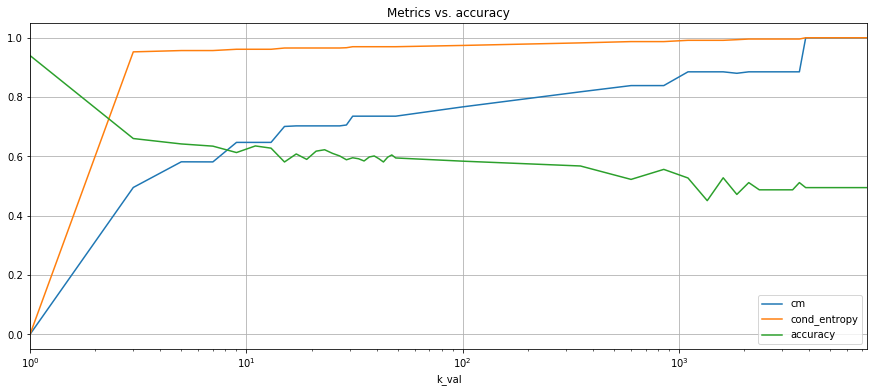

In [101]:
data.plot("k_val", ["cm", "cond_entropy", "accuracy"], figsize=(15,6), grid=True, logx=True, title="Metrics vs. accuracy")

# Linear Regression



In [99]:
from sklearn.linear_model import LinearRegression

def regress(regressors):
    X = data[regressors]
    y = data["accuracy"]

    reg = LinearRegression()
    reg.fit(X, y)
    print(f"R2 Score: {reg.score(X,y)}")
    print(f"Coeffs: {reg.coef_}")
    print(f"Intercept: {reg.intercept_}")
    return reg.coef_, reg.intercept_


### Classification Metric

R2 Score: 0.9272270983827473
Coeffs: [-0.47349582]
Intercept: 0.9313110362141946


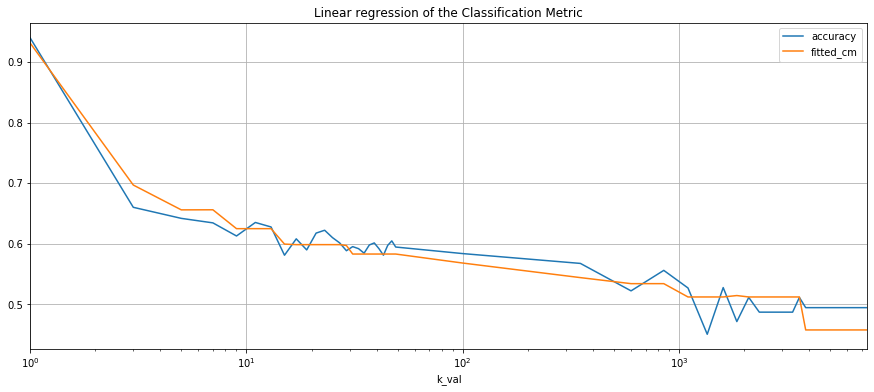

In [103]:
coeff, intercept = regress(["cm"])
cm_reg = data[["k_val", "accuracy", "cm"]]
cm_reg["fitted_cm"] = coeff*cm_reg["cm"] + intercept
cm_reg.plot("k_val", ["accuracy", "fitted_cm"], figsize=(15,6), grid=True,
            logx=True, title="Linear regression of the Classification Metric")

### Conditional Entropy

R2 Score: 0.6098098923651292
Coeffs: [-0.41188189]
Intercept: 0.9680539344499206


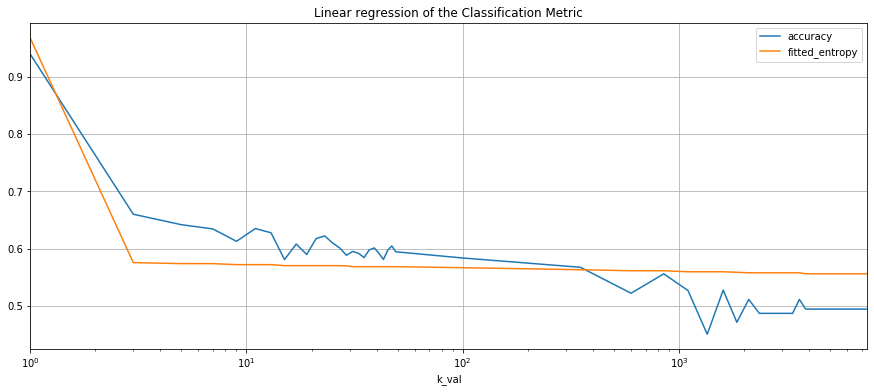

In [106]:
coeff, intercept = regress(["cond_entropy"])
entropy_reg = data[["k_val", "accuracy", "cond_entropy"]]
entropy_reg["fitted_entropy"] = coeff*entropy_reg["cond_entropy"] + intercept
entropy_reg.plot("k_val", ["accuracy", "fitted_entropy"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of the Conditional Entropy")

### Both

**Notice that the influence of entropy nears 0... Better predictor is CM**

R2 Score: 0.9282201832332836
Coeffs: [-0.02716415 -0.45346543]
Intercept: 0.942151230842108


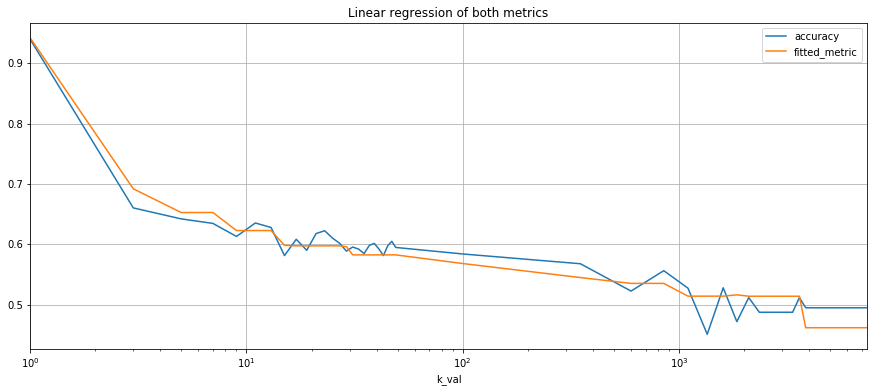

In [109]:
coeffs, intercept = regress(["cond_entropy", "cm"])
m_reg = data[["k_val", "accuracy", "cond_entropy", "cm"]]
m_reg["fitted_metric"] = coeffs[0]*m_reg["cond_entropy"] + coeffs[1]*m_reg["cm"] + intercept
m_reg.plot("k_val", ["accuracy", "fitted_metric"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of both metrics")